# In case, the file import data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/Thesis_st121166
# !ls

/content/drive/MyDrive/Colab Notebooks/Thesis_st121166


In [ ]:
# Install libraries
!pip install mne
!pip install PyWavelets
# !pip install pyriemann

     |████████████████████████████████| 7.4 MB 20.9 MB/s 


## Reference paper
- Paper 

## Reference for the data
- https://data.mendeley.com/datasets/wb6yvr725d/4

    - EEG electrodes (Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, T6, Fz, Cz, Pz) were placed according to the 10–20 International System,
    - Sampling frequency = 200 Hz
    - Bandpass filter at 0.5-40Hz
    - Notch filter at 50 Hz
    - Each dataset has 30 seconds duration
    - OAs occur due to eye moment and eye-blinks and have freuqncy ranges of 0-7 Hz and 8-13 Hz

## Preparing data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io
import scipy.signal
import seaborn as sns; sns.set_style("darkgrid") # styling
import pywt

import mne
from mne.time_frequency import psd_welch
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

number_subjects = 54
initial_fs = 200
EEG_electrodes = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 
                  'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

initial_pure_dataset = scipy.io.loadmat("Datasets/semi_EEG-EOG/Pure_Data.mat")
initial_cont_dataset = scipy.io.loadmat("Datasets/semi_EEG-EOG/Contaminated_Data.mat")
initial_HEOG = scipy.io.loadmat("Datasets/semi_EEG-EOG/HEOG.mat")
initial_VEOG =scipy.io.loadmat("Datasets/semi_EEG-EOG/VEOG.mat")

In [ ]:
def createSubplot(n):
    fig,axs = plt.subplots(n,figsize=(15,8))
    fig.tight_layout(pad=3.0)
    return fig,axs

### Calculte FFT
def next_pow2(x):
    return 1<<(x-1).bit_length()

def calculate_FFT(inputSignal, fs, n_zeropad=0, window="False", timescaling=1):
    
    my_signal = inputSignal.copy()
    
    if window != "False":
        window = get_window(window, inputSignal.shape[0])
        my_signal *= window # multiply signal by window to reduce fluctuation in frequency-domain
        
    time_zeropadding =  np.hstack((my_signal, np.zeros(int(n_zeropad)))) # zero-padding in time-domain
    nfft = time_zeropadding.shape[0]           # get the number of samples in the signal
#     nfft = next_pow2(nfft)                                     # FFT is more efficient when using number of samples is part of power of 2
    fft = np.fft.fft(my_signal,nfft)[:int(np.ceil(nfft/2))]             # extract only the 1st half of the result (one-side frequency
    fft = fft*2                                                # multiply magnitude by 2 after select only one-side frequency
    corr_mag_fft = np.abs(fft)/nfft * (nfft / my_signal.shape[0]) / timescaling

    df = fs/nfft                                   # finding frequency resolution
    xfft = np.arange(0, fs/2,df)                   # correcting x-axis
    
    return xfft, corr_mag_fft

def grab_children(father):
    nestedDict_to_lists = []
    for key, value in father.items():
#         print(f"value is {value}")
        if type(value) == dict:
#             print(f"It is dictionary")
#             print('-'*100)
#             print(value)
            nestedDict_to_lists.append(grab_children(value))
#         elif type(father).__module__ == np.__name__:
        else:
#             print(type(value))
#             print(f"It is link list")
            nestedDict_to_lists.append(value)
#             print(nestedDict_to_lists)
#             print('='*100)
    return nestedDict_to_lists

In [ ]:
def ExtractOnlyEEG(dict_inputEEG):
    outputEEG = dict()
    for key, value in dict_inputEEG.items():
        if key not in ['__header__', '__version__', '__globals__']:
            outputEEG[key] = value
    return outputEEG

extracted_pure_eeg = ExtractOnlyEEG(initial_pure_dataset)
extracted_cont_eeg = ExtractOnlyEEG(initial_cont_dataset)
extracted_HEOG = ExtractOnlyEEG(initial_HEOG)
extracted_VEOG = ExtractOnlyEEG(initial_VEOG)

def findMinumumEEGLength(dict_inputEEG):
    minEEGLength = int()
    for idx, eeg_values in enumerate(dict_inputEEG.values()):
        EEGLength = eeg_values.shape[-1]
        if idx == 0:
            minEEGLength = EEGLength
        elif minEEGLength > EEGLength:
            minEEGLength = EEGLength
    return minEEGLength

minEEGLength = findMinumumEEGLength(extracted_cont_eeg)
print(f"Minumum EEG length: {minEEGLength}")

# sampling frequency = 200 Hz and 26 seconds
selectedEEGLength = 200 * 26
print(f"Selected EEG length: {selectedEEGLength}")

Minumum EEG length: 5401
Selected EEG length: 5200


In [ ]:
def SelectLengthChannel(dict_inputEEG, selectEEGLength):
    """
    selectEEGChannel get an index according to the data's channels information like Fp1 = '0'
    """
    dict_oneChannelEEG = dict()
    for key, value in dict_inputEEG.items():
        dict_oneChannelEEG[key] = value[:, :selectEEGLength]
    return dict_oneChannelEEG

selectedLength_pureEEG = SelectLengthChannel(dict_inputEEG=extracted_pure_eeg,
                                              selectEEGLength=selectedEEGLength)
selectedLength_contEEG = SelectLengthChannel(dict_inputEEG=extracted_cont_eeg,
                                              selectEEGLength=selectedEEGLength)
selectedLength_HEOG = SelectLengthChannel(dict_inputEEG=extracted_HEOG,
                                              selectEEGLength=selectedEEGLength)
selectedLength_VEOG = SelectLengthChannel(dict_inputEEG=extracted_VEOG,
                                              selectEEGLength=selectedEEGLength)

print(f"Number of subjects: {len(list(extracted_pure_eeg.keys()))}")
print(f"The number of samples of contaminated EEG in one subject: {selectedLength_contEEG['sim1_con'].shape}")

Number of subjects: 54
The number of samples of contaminated EEG in one subject: (19, 5200)


In [ ]:
# Save data for calculating performance 
reconstructed_pure_EEG = np.array(grab_children(selectedLength_pureEEG))
reconstructed_cont_EEG = np.array(grab_children(selectedLength_contEEG))

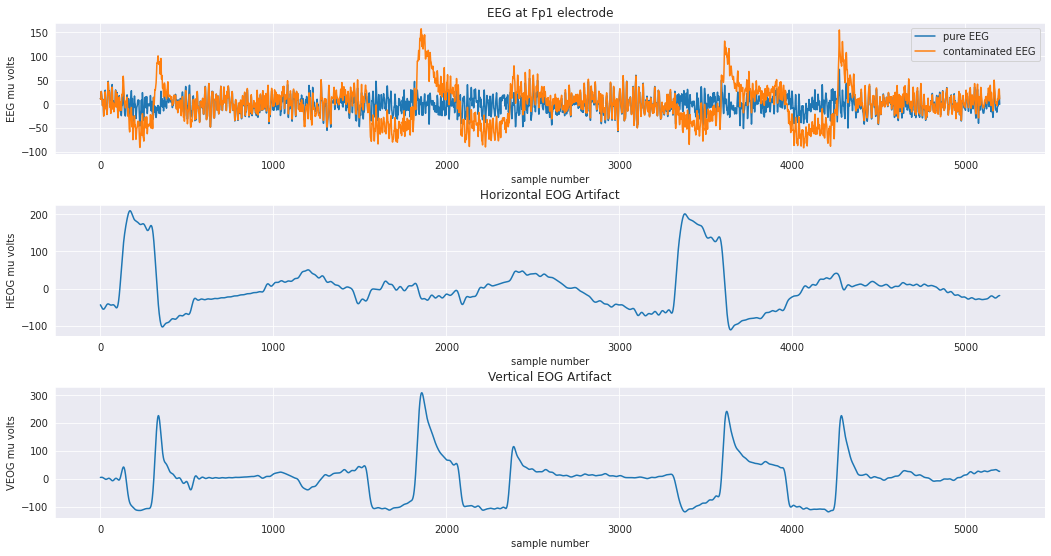

In [ ]:
index_selected_electrode = 0

# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
plt.plot(selectedLength_pureEEG["sim1_resampled"][index_selected_electrode], label="pure EEG") 
plt.plot(selectedLength_contEEG["sim1_con"][index_selected_electrode], label="contaminated EEG") 
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(selectedLength_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(selectedLength_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

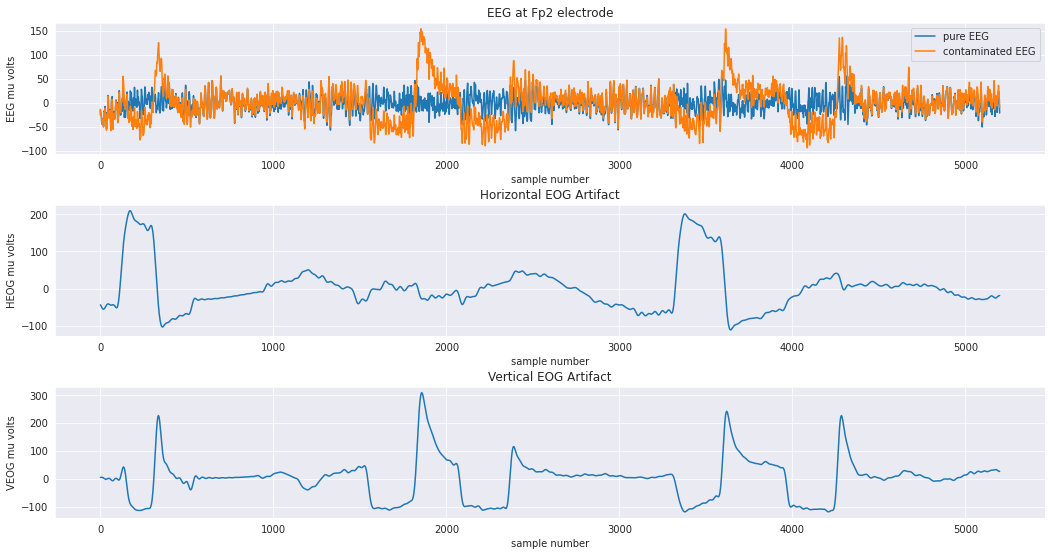

In [ ]:
index_selected_electrode = 1

# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
plt.plot(selectedLength_pureEEG["sim1_resampled"][index_selected_electrode], label="pure EEG") 
plt.plot(selectedLength_contEEG["sim1_con"][index_selected_electrode], label="contaminated EEG") 
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(selectedLength_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(selectedLength_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

## Function for ICA

In [ ]:
# # 1st Version (Having EOG signals)
# def df_to_raw(df):
#     sfreq = 200 # According to frequency sampling of data
    
#     ch_names = list(df.columns)
#     ch_types = (['eeg'] * (len(df.columns) - 2)) + ['eog'] + ['eog']

# #     ch_names = list(df.index)
# #     ch_types = ['eeg'] * len(df.index) 
    
#     ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

#     df = df.T  #mne looks at the tranpose() format
# #     df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

#     info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

#     raw = mne.io.RawArray(df, info)
#     raw.set_montage(ten_twenty_montage)

#     #try plotting the raw data of its power spectral density
#     raw.plot_psd()

#     return raw

# 2nd Version (No EOG signals)
def df_to_raw(df):
    sfreq = 200 # According to frequency sampling of data

    ch_names = list(df.columns)
    ch_types = ['eeg'] * len(df.columns) 
    
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
#     df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #try plotting the raw data of its power spectral density
    raw.plot_psd()

    return raw

In [ ]:
def denoising_EEG_withICA(raw_object):    
    #  3.1 Notch Filter
    # # data's frequency sampling / 2 based on Nyquist Theorem
    # raw_object.notch_filter(np.arange(50, sfreq/2, 50), filter_length='auto', phase='zero') 
    # raw_object.plot_psd()

    # 3.2 Band pass Filter
    # #Filter code looks like this
    # raw_object.filter(4,50, method='iir')
    # raw_object.plot_psd()

    filt_raw_object = raw_object.copy()
    filt_raw_object.load_data().filter(l_freq=1., h_freq=None)
#     filt_raw_object.plot_psd()

    # set up and fit the ICA
    # Infomax
    ica = ICA(n_components=n_EEG_electrodes, method="infomax", fit_params=dict(extended=True), random_state=32)
    ica.fit(filt_raw_object)

#     # Extend Infomax
#     ica = ICA(n_components=n_EEG_electrodes, method="infomax", fit_params=dict(extended=True), random_state=32)
#     ica.fit(filt_raw_object)

#     ica.plot_sources(filt_raw_object)
#     ica.plot_components()

    # 3.3B Using a simulated channel to select ICA components (No EOG channels)
    ica.exclude = []
    # find which ICs match the EOG pattern
    eog_indices, eog_scores = ica.find_bads_eog(filt_raw_object, ch_name='Fp1', threshold=0.5, measure='correlation')
    ica.exclude = eog_indices

#     # barplot of ICA component "EOG match" scores
#     ica.plot_scores(eog_scores)

#     # plot diagnostics
#     ica.plot_properties(filt_raw_object, picks=eog_indices)

#     # plot ICs applied to raw_object data, with EOG matches highlighted
#     ica.plot_sources(filt_raw_object)

#     # plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
#     ica.plot_sources(eog_evoked)


    # 3.4 Applying ICA
    # ica.apply() changes the raw_object object in-place, so let's make a copy first for comparison:
    orig_raw_object = raw_object.copy()  #we apply ica to raw_object
    denoised_raw_object = ica.apply(raw_object)

#     regexp = r'(F)|(AF)'
#     artifact_picks = mne.pick_channels_regexp(raw_object.ch_names, regexp=regexp)

#     orig_raw_object.plot(order=artifact_picks, n_channels=len(artifact_picks))
#     raw_object.plot(order=artifact_picks, n_channels=len(artifact_picks), start=1)
    return orig_raw_object, denoised_raw_object

In [ ]:
list_selected_cont_EEG_subjects =[]
list_denoised_EEG_subjects = []

for n_selecting_subject in range(number_subjects):
    
    ## Creating raw object
    selected_pure_EEG= selectedLength_pureEEG[list(selectedLength_pureEEG.keys())[n_selecting_subject]]
    selected_cont_EEG= selectedLength_contEEG[list(selectedLength_contEEG.keys())[n_selecting_subject]]
    selected_HEOG = selectedLength_HEOG[list(selectedLength_HEOG.keys())[n_selecting_subject]]
    selected_VEOG = selectedLength_VEOG[list(selectedLength_VEOG.keys())[n_selecting_subject]]

    # # 1st Version (Having EOG signals)
    # data_EEG = np.vstack((selected_cont_EEG, 
    #                       selected_HEOG, 
    #                       selected_VEOG)).transpose()

    # column_values_for_df_EEG = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 
    #                            'C4', 'P3', 'P4', 'O1', 'O2', 
    #                            'F7', 'F8', 'T3', 'T4', 'T5', 
    #                            'T6', 'Fz', 'Cz', 'Pz','HEOG', 'VEOG']

    # 2nd Version (No EOG signals)
    data_EEG = selected_cont_EEG.transpose()

    column_values_for_df_EEG = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 
                               'C4', 'P3', 'P4', 'O1', 'O2', 
                               'F7', 'F8', 'T3', 'T4', 'T5', 
                               'T6', 'Fz', 'Cz', 'Pz']


    df_EEG = pd.DataFrame(data=data_EEG,
                          columns=column_values_for_df_EEG)
    
    # Each dataset has 19 EEG electrodes and around 5601 samples (30s duration * 200 frequency sampling)
    sfreq = 200
    n_samples = df_EEG.shape[0]

    # # 1st Version (Having EOG signals)
    # n_EOG_electrodes = 2
    # n_EEG_electrodes = df_EEG.shape[1] - n_EOG_electrodes

    # 2nd Version (No EOG signals)
    n_EOG_electrodes = 0
    n_EEG_electrodes = df_EEG.shape[1] - n_EOG_electrodes
    
    raw = df_to_raw(df_EEG)
    
    # ICA.apply probably affects the input of raw object (selected_cont_EEG in this case)
    result_fromICA = denoising_EEG_withICA(raw_object=raw)
    
    list_selected_cont_EEG_subjects.append(result_fromICA[0]._data.copy())
    list_denoised_EEG_subjects.append(result_fromICA[1]._data.copy())
    
#     break

In [ ]:
data_EEG.shape

(5200, 19)

In [ ]:
df_EEG.shape

(5200, 19)

In [ ]:
list_selected_cont_EEG_subjects[0].shape

(19, 5200)

## Performance metrics

In [ ]:
# def calculate_SAR(input_cont_EEG,input_denoised_EEG):
#     """
#     Calculate Signal to Artifact Ratio (SAR)
#     """
#     SAR = 10*np.log(np.std(input_cont_EEG) / np.std(input_cont_EEG-input_denoised_EEG))
#     return SAR


# def calculate_RMSE(input_pure_EEG, input_denoised_EEG):
#     """
#     Calculate RMSE in dB scale (log based E)
#     """
#     diff_EEG = input_pure_EEG - input_denoised_EEG
# #     print(f"Shape of pure_EEG: {pure_EEG.shape}")
# #     print(f"Shape of cont_EEG: {denoised_EEG.shape}")
# #     print(f"Shape of diff_EEG: {diff_EEG.shape}")
# #     print('-'*50)
#     RMSE = np.mean(np.power(diff_EEG,2))
#     return RMSE

In [ ]:
# subjects_manyCHs_SAR = {}

# for idx_e_subject in range(number_subjects):
#     manyCH_SAR = []
#     manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
#     manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
#     numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
#     for idx_channel in range(numbers_EEG_CH):
#         oneCH_SAR = calculate_SAR(input_cont_EEG=manyCH_contEEG[idx_channel], 
#                                   input_denoised_EEG=manyCH_denoisedEEG[idx_channel])
#         manyCH_SAR.append(oneCH_SAR)
#     subjects_manyCHs_SAR[list_denoised_EEG_keys[idx_e_subject]] = manyCH_SAR
    
# # Create DataFrame for SAR
# df_SAR = pd.DataFrame(data=subjects_manyCHs_SAR, 
#                       index= EEG_electrodes,
#                       columns=subjects_manyCHs_SAR.keys())

# print(f"Avg. SAR of each Electrodes: \n{df_SAR.mean(axis=1)}")
# print(f"Grand Avg. SAR: {np.mean(df_SAR.mean(axis=1))}")
# df_SAR

In [ ]:
# subjects_manyCHs_RMSE = {}

# for idx_e_subject in range(number_subjects):
#     manyCH_RMSE = []
#     manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
#     manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
#     numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
#     for idx_channel in range(numbers_EEG_CH):
#         oneCH_RMSE = calculate_RMSE(input_pure_EEG=manyCH_pureEEG[idx_channel], 
#                           input_denoised_EEG=manyCH_denoisedEEG[idx_channel])
#         manyCH_RMSE.append(oneCH_RMSE)
#     subjects_manyCHs_RMSE[list_denoised_EEG_keys[idx_e_subject]] = manyCH_RMSE
    
# # Create DataFrame for RMSE
# df_RMSE = pd.DataFrame(data=subjects_manyCHs_RMSE, 
#                       index= EEG_electrodes,
#                       columns=subjects_manyCHs_RMSE.keys())

# print(f"Avg. RMSE of each Electrodes: \n{df_RMSE.mean(axis=1)}")
# print(f"Grand Avg. RMSE: {np.mean(df_RMSE.mean(axis=1))}")
# df_RMSE

In [ ]:
# Prepare data for calculating metrics
reconstructed_pure_EEG = reconstructed_pure_EEG
reconstructed_cont_EEG = reconstructed_cont_EEG
reconstructed_denoised_EEG = np.array(list_denoised_EEG_subjects)
print(reconstructed_denoised_EEG.shape)

# Hyperparameters for calculating metrics
NUMBER_SUBJECTS = reconstructed_denoised_EEG.shape[0]
list_denoised_EEG_keys = list(selectedLength_contEEG.keys())
print(list_denoised_EEG_keys)

# Get some samples
print(reconstructed_pure_EEG[0,0,:10])
print(reconstructed_cont_EEG[0,0,:10])
print(reconstructed_denoised_EEG[0,0,:10])

(54, 19, 5200)
['sim1_con', 'sim2_con', 'sim3_con', 'sim4_con', 'sim5_con', 'sim6_con', 'sim7_con', 'sim8_con', 'sim9_con', 'sim10_con', 'sim11_con', 'sim12_con', 'sim13_con', 'sim14_con', 'sim15_con', 'sim16_con', 'sim17_con', 'sim18_con', 'sim19_con', 'sim20_con', 'sim21_con', 'sim22_con', 'sim23_con', 'sim24_con', 'sim25_con', 'sim26_con', 'sim27_con', 'sim28_con', 'sim29_con', 'sim30_con', 'sim31_con', 'sim32_con', 'sim33_con', 'sim34_con', 'sim35_con', 'sim36_con', 'sim37_con', 'sim38_con', 'sim39_con', 'sim40_con', 'sim41_con', 'sim42_con', 'sim43_con', 'sim44_con', 'sim45_con', 'sim46_con', 'sim47_con', 'sim48_con', 'sim49_con', 'sim50_con', 'sim51_con', 'sim52_con', 'sim53_con', 'sim54_con']
[11.333812  12.3151865 10.298577  17.469858  23.68372   26.498333
 23.249773  18.782053  15.634403  13.411441 ]
[11.31871986 12.29839897 10.28273773 17.45271301 23.6586895  26.45616531
 23.17921638 18.67058563 15.468853   13.17694283]
[18.26633988 27.67564966 27.08405491 33.14555608 36.8940

In [ ]:
# Save Numpy to Files
"""
5 EOG artifact removal techniques
- 'WT'
- 'ICA'
- 'wICA'
- 'WNN'
- 'SRGAN'
"""
ar_techniques = 'ICA'

np.save(
    file=f'Result/before_after_removal/{ar_techniques}_pure_EEG',
    arr=reconstructed_pure_EEG,
    allow_pickle=True, fix_imports=True)
np.save(
    file=f'Result/before_after_removal/{ar_techniques}_cont_EEG',
    arr=reconstructed_cont_EEG,
    allow_pickle=True, fix_imports=True)
np.save(
    file=f'Result/before_after_removal/{ar_techniques}_denoised_EEG',
    arr=reconstructed_denoised_EEG,
    allow_pickle=True, fix_imports=True)

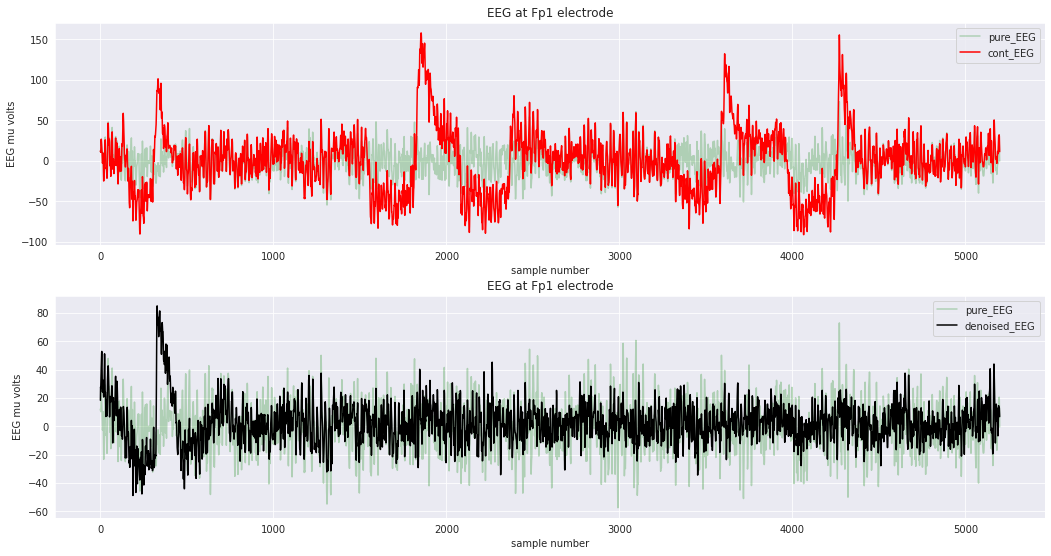

In [ ]:
selected_idx_subject = 0
selected_idx_electrode = 0

# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(2)

plt.sca(axs[0])
plt.plot(reconstructed_pure_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="pure_EEG", color="g", alpha=0.25) 
plt.plot(reconstructed_cont_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="cont_EEG", color="r") 
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[selected_idx_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(reconstructed_pure_EEG[selected_idx_subject,
                                selected_idx_electrode,:], label="pure_EEG", color="g", alpha=0.25) 
plt.plot(reconstructed_denoised_EEG[selected_idx_subject,
                                    selected_idx_electrode,:], label="denoised_EEG", color="k") 
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[selected_idx_electrode]} electrode")
plt.legend(loc="upper right")
plt.show()

In [ ]:
def calculate_RMSE(pure_EEG_e_CH, denoised_EEG_e_CH):
    """
    Calculate RMSE in dB scale (log based E)
    """
    diff_EEG = pure_EEG_e_CH - denoised_EEG_e_CH
    RMSE = np.mean(np.power(diff_EEG,2))
    return RMSE

def calculate_SAR(cont_EEG_e_CH,denoised_EEG_e_CH):
    """
    Calculate Signal to Artifact Ratio (SAR)
    """
    SAR = 10*np.log(np.std(cont_EEG_e_CH) / np.std(cont_EEG_e_CH-denoised_EEG_e_CH))
    return SAR

def calculate_MSC(cont_EEG_e_CH, denoised_EEG_e_CH):
    """
    Calculate Magnitude Squared Coherence
    """
    MSC = scipy.signal.coherence(x=cont_EEG_e_CH, y=denoised_EEG_e_CH,
                                 fs=200, window='hann', nperseg=200,
                                 noverlap=None, nfft=None, detrend=False,
                                 axis=-1)
    return MSC

def calculate_PSD(EEG_e_CH):
    """
    Calculate Magnitude Squared Coherence
    """
    PSD = scipy.signal.welch(x=EEG_e_CH,
                             fs=200, window='hann', nperseg=200, 
                             noverlap=None, nfft=None, detrend=False,
                             scaling='density',
                             axis=-1)
    return PSD

In [ ]:
pure_denoised_RMSE_subjs = {}

for idx_e_subject in range(number_subjects):
    manyCH_RMSE = []
    manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_RMSE = calculate_RMSE(
            pure_EEG_e_CH=manyCH_pureEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_RMSE.append(oneCH_RMSE)

    pure_denoised_RMSE_subjs[list_denoised_EEG_keys[idx_e_subject]] = manyCH_RMSE
    
# Create DataFrame for RMSE
df_RMSE = pd.DataFrame(data=pure_denoised_RMSE_subjs, 
                      index= EEG_electrodes,
                      columns=pure_denoised_RMSE_subjs.keys())

print(f"Avg. RMSE of each Electrodes: \n{df_RMSE.mean(axis=1)}")
print(f"Grand Avg. RMSE: {np.mean(df_RMSE.mean(axis=1))}")
df_RMSE

Avg. RMSE of each Electrodes: 
Fp1    391.382867
Fp2    384.521605
F3      53.822406
F4      46.526036
C3      22.499889
C4      16.797123
P3      11.443099
P4       6.583784
O1       6.322854
O2       8.096202
F7     160.021408
F8     164.500037
T3      27.293318
T4      26.097422
T5       8.792932
T6       4.992980
Fz      98.458050
Cz      36.912230
Pz      14.908902
dtype: float64
Grand Avg. RMSE: 78.41963913454732


,sim1_con,sim2_con,sim3_con,sim4_con,sim5_con,sim6_con,sim7_con,sim8_con,sim9_con,sim10_con,sim11_con,sim12_con,sim13_con,sim14_con,sim15_con,sim16_con,sim17_con,sim18_con,sim19_con,sim20_con,sim21_con,sim22_con,sim23_con,sim24_con,sim25_con,sim26_con,sim27_con,sim28_con,sim29_con,sim30_con,sim31_con,sim32_con,sim33_con,sim34_con,sim35_con,sim36_con,sim37_con,sim38_con,sim39_con,sim40_con,sim41_con,sim42_con,sim43_con,sim44_con,sim45_con,sim46_con,sim47_con,sim48_con,sim49_con,sim50_con,sim51_con,sim52_con,sim53_con,sim54_con
Fp1,281.354388,365.292371,263.906802,107.238085,626.535382,584.371965,448.170166,564.790709,359.331744,434.316098,228.017692,308.857315,283.724594,632.223673,291.127408,244.042476,227.324830,510.786611,298.363727,92.257458,417.655281,143.664936,683.815548,62.386306,277.407490,120.468260,298.492462,202.596131,790.064976,1123.104642,975.695203,503.709589,281.585518,391.711740,550.252950,149.299008,300.693316,471.409359,526.994505,346.195752,360.257349,474.656000,130.291075,162.114076,600.756410,593.269099,733.994628,240.889147,339.742402,300.639139,669.491956,413.164413,63.730451,282.442207
Fp2,238.561486,334.692526,238.505307,110.485060,525.141743,584.156353,428.698070,565.959900,357.727357,428.798106,225.387831,308.268063,287.699941,632.678146,291.139668,245.023268,222.776823,499.160541,295.500468,92.671970,411.801432,146.145003,784.734765,62.452756,295.962057,112.057250,225.533418,177.185785,780.191110,1119.525281,923.657683,472.317538,290.900032,400.262691,643.552238,114.855458,298.274922,472.904763,519.274754,347.193485,342.040761,307.366997,131.076753,159.917373,580.641805,591.704949,814.633018,241.018376,341.591536,309.958880,668.789635,419.300985,62.462514,281.848022
F3,167.188056,186.197672,45.725523,17.293422,81.039108,23.710192,161.771070,31.810166,18.646074,12.306829,9.032163,9.779940,14.999217,17.126703,12.493561,15.215095,31.871165,26.422925,16.506620,11.039431,67.151369,23.821837,148.655816,7.253887,36.703469,22.967949,224.081192,183.592922,51.473826,50.981612,271.320353,38.893194,25.314387,14.518386,44.650451,91.340241,33.856848,11.005736,26.666578,18.472690,30.982399,302.413799,14.321232,14.680346,25.179614,63.500277,30.443341,10.790730,8.896891,13.810030,20.402529,22.694268,26.702149,18.694651
F4,146.707644,164.203830,35.717809,18.373004,81.211476,24.107121,133.607665,32.347304,18.604271,11.668352,6.807042,9.779535,15.662565,16.564521,12.146972,15.405876,32.033674,25.147579,16.884009,11.027353,75.622423,24.994549,222.274361,7.667124,34.580870,14.745219,163.171561,157.627303,32.600892,51.886280,176.392276,32.830217,30.869915,13.989930,89.266542,46.225166,33.234108,11.146462,20.882177,21.524646,20.223407,130.821323,13.743689,14.721041,23.395557,63.537805,28.802170,10.862600,8.805273,15.001127,20.226696,22.421435,26.494627,23.809558
C3,36.013732,79.767672,18.720252,4.168710,14.997963,4.707798,115.158565,5.509166,3.883755,2.826719,1.870500,1.614549,3.559083,2.482610,3.743624,4.191861,9.810223,4.057796,3.017314,4.153832,11.981833,5.978213,32.909041,1.677767,9.671222,2.991709,182.347680,119.456764,7.858855,8.507260,152.732724,7.468892,10.076288,4.199424,8.846196,37.997412,8.364118,1.760256,3.981782,9.259647,6.538669,201.969032,3.541704,2.621339,5.170889,12.407011,4.694899,2.090605,1.345512,2.357465,3.604425,4.038980,6.901622,5.389033
C4,43.606588,34.737721,13.796068,3.539872,11.507412,4.364704,81.254697,5.647864,4.749699,1.973110,1.249055,2.898126,4.475032,2.457410,3.559970,3.981318,9.526702,4.031817,3.420127,3.373729,20.730422,8.748021,57.798971,3.332929,7.624281,2.626559,145.099335,89.820694,6.140631,8.796352,81.648106,6.239881,9.420179,2.897736,34.632713,14.953277,7.542512,1.947535,3.351261,11.156457,4.643791,78.367664,3.744915,2.637507,3.983820,12.523057,4.370990,2.107135,1.326854,2.330419,4.524136,3.929212,6.992422,6.903830
P3,46.864535,8.221711,4.209330,1.584881,9.293333,2.523455,58.870195,2.621046,2.931818,1.576771,0.607133,0.937038,4.087537,1.591401,2.889480,1.469125,10.119873,2.594256,2

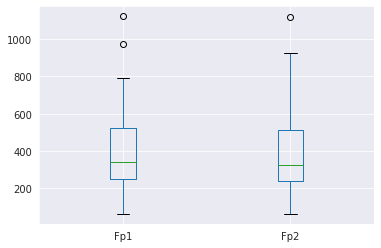

In [ ]:
df_RMSE.copy().transpose().boxplot(['Fp1', 'Fp2'])

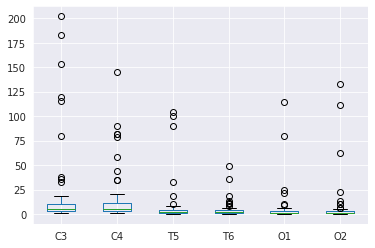

In [ ]:
df_RMSE.copy().transpose().boxplot(['C3', 'C4', 'T5', 'T6', 'O1', 'O2'])

In [ ]:
cont_denoised_SAR_subjs = {}

for idx_e_subject in range(number_subjects):
    manyCH_SAR = []
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_SAR = calculate_SAR(
            cont_EEG_e_CH=manyCH_contEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_SAR.append(oneCH_SAR)

    cont_denoised_SAR_subjs[list_denoised_EEG_keys[idx_e_subject]] = manyCH_SAR
    
# Create DataFrame for SAR
df_SAR = pd.DataFrame(data=cont_denoised_SAR_subjs, 
                      index= EEG_electrodes,
                      columns=cont_denoised_SAR_subjs.keys())

print(f"Avg. SAR of each Electrodes: \n{df_SAR.mean(axis=1)}")
print(f"Grand Avg. SAR: {np.mean(df_SAR.mean(axis=1))}")
df_SAR

Avg. SAR of each Electrodes: 
Fp1     1.575871
Fp2     1.794375
F3      3.361179
F4      3.652062
C3      7.900708
C4      8.468269
P3     13.301853
P4     14.201187
O1     17.476746
O2     19.888313
F7      5.358554
F8      5.848436
T3     10.048037
T4     11.579965
T5     11.818374
T6     14.146273
Fz      4.647428
Cz      8.631766
Pz     13.969773
dtype: float64
Grand Avg. SAR: 9.35100893234216


,sim1_con,sim2_con,sim3_con,sim4_con,sim5_con,sim6_con,sim7_con,sim8_con,sim9_con,sim10_con,sim11_con,sim12_con,sim13_con,sim14_con,sim15_con,sim16_con,sim17_con,sim18_con,sim19_con,sim20_con,sim21_con,sim22_con,sim23_con,sim24_con,sim25_con,sim26_con,sim27_con,sim28_con,sim29_con,sim30_con,sim31_con,sim32_con,sim33_con,sim34_con,sim35_con,sim36_con,sim37_con,sim38_con,sim39_con,sim40_con,sim41_con,sim42_con,sim43_con,sim44_con,sim45_con,sim46_con,sim47_con,sim48_con,sim49_con,sim50_con,sim51_con,sim52_con,sim53_con,sim54_con
Fp1,1.124837,2.313062,0.674365,2.392901,3.696398,3.839012,1.939471,1.227212,0.345014,1.230626,1.168323,1.133720,1.521119,3.891406,2.745064,2.072923,1.584949,1.301053,0.756899,1.194190,1.068116,1.153292,0.335802,1.084469,1.872886,0.707107,1.348453,2.157491,2.907754,3.278848,4.243414,2.591842,2.383698,1.881436,2.369780,-0.306940,0.874659,2.338920,1.483105,1.832825,1.749503,0.779017,1.436353,0.987506,1.197293,2.763303,-0.123514,0.262282,0.416163,-0.132441,0.885890,0.482951,0.662456,1.970781
Fp2,1.214562,2.216287,0.652371,1.886354,4.054400,3.685326,1.560409,1.194266,0.412270,1.177955,2.018559,1.161597,1.284273,3.961426,3.007371,2.037504,2.483741,1.770590,1.404442,1.329217,1.271397,1.074125,0.799064,2.058477,3.170085,0.928870,0.650729,1.586950,2.119656,3.784024,5.608150,3.478054,1.811960,1.449885,1.639285,0.608124,1.094029,2.177672,1.724791,1.609815,1.704099,1.389572,1.419890,0.820866,2.372223,2.739169,4.092397,0.473838,0.363251,-0.230211,0.804408,0.251975,1.155756,2.380953
F3,2.452382,2.805698,3.138960,7.868855,5.556579,4.876507,1.509975,4.269312,0.959567,1.601479,2.039251,2.970176,4.072440,3.865344,6.505010,6.467814,9.334670,2.938794,3.615744,5.520199,3.674009,4.881095,1.789636,4.402630,2.681551,2.057576,1.484158,2.430601,6.413839,4.089386,0.902128,6.793868,4.361722,5.991983,3.313910,0.091029,1.408066,2.835420,2.659606,2.883157,5.265052,1.844192,3.325100,4.578392,0.740267,3.079047,0.422812,1.649087,2.049125,0.970922,1.652593,1.677885,3.756829,2.978263
F4,6.268507,2.718726,3.242870,6.869817,4.581165,4.412814,0.911178,3.912871,0.682423,2.140291,5.180527,2.886736,3.414963,3.568831,6.708478,5.469762,9.545481,3.886078,4.737490,6.462721,3.997633,4.850399,1.203569,8.586254,3.010387,2.801616,1.964844,2.844603,3.436227,4.985005,2.434751,8.412757,3.400483,4.469429,3.194658,1.618870,2.070809,2.300176,2.730213,2.723170,4.935929,3.472186,3.184252,3.805385,2.168525,3.058127,1.061829,2.384330,1.668028,1.278239,0.997070,1.545312,4.363276,4.651294
C3,9.986046,7.635675,7.314296,18.468221,10.479637,9.506320,1.572928,8.622974,3.280511,3.672389,5.815984,6.920987,9.221736,10.148512,13.669213,13.862371,23.872875,8.277876,9.697939,16.465135,9.105323,9.471116,5.802077,10.540411,6.428266,7.064373,1.687774,3.021273,6.877643,7.953117,1.197232,12.618752,7.749001,14.321204,4.841512,2.205782,4.714585,7.557691,7.616512,6.977545,10.895571,2.627634,7.986579,10.801388,4.083211,7.426801,2.739937,5.184712,5.326194,3.917325,6.090747,6.349712,8.728132,8.237471
C4,8.492352,10.245659,7.349240,15.000521,7.990959,7.578850,1.633473,8.177349,3.348265,6.089724,11.161220,9.657251,6.522923,8.707724,13.072411,13.218364,27.293986,9.493243,15.581436,17.419063,8.003656,8.307066,2.673612,18.643317,6.717561,7.302033,2.766582,5.102393,8.200662,7.173917,2.932380,15.241555,10.148887,11.213548,5.797436,3.167676,5.849826,6.926978,8.084697,6.712400,9.400571,5.691069,7.267488,10.492736,5.707965,7.846684,4.832666,6.491018,5.256129,4.588197,6.437852,4.624520,8.735729,10.913708
P3,12.907610,17.631632,14.199357,19.574863,11.607562,12.291695,4.226668,12.542644,4.978593,7.081216,10.372469,9.612584,13.297842,18.157081,14.681413,16.688887,64.832266,16.979910,13.621250,22.905754,13.547288,13.925487,4.703331,14.536827,13.909555,14.253391,5.217745,8.596063,13.989166,11.327371,14.356423,12.414782,10.240094,20.397905,10.397398,4.148452,11.588375,10.202055,16.022387,12.839627,14.937665,5.027697,11.839233,17.463623,10.271789,19.763505,6.730393,10.887125,7.987912,7.263106,12.351756,1

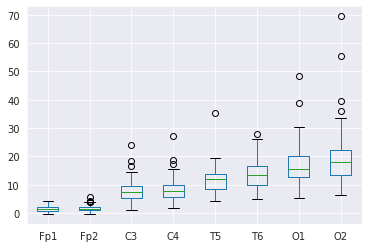

In [ ]:
df_SAR.copy().transpose().boxplot(['Fp1','Fp2','C3', 'C4', 'T5', 'T6', 'O1', 'O2'])

The shape of cont_denoised_MSC_subjs: (54, 19, 2, 101)


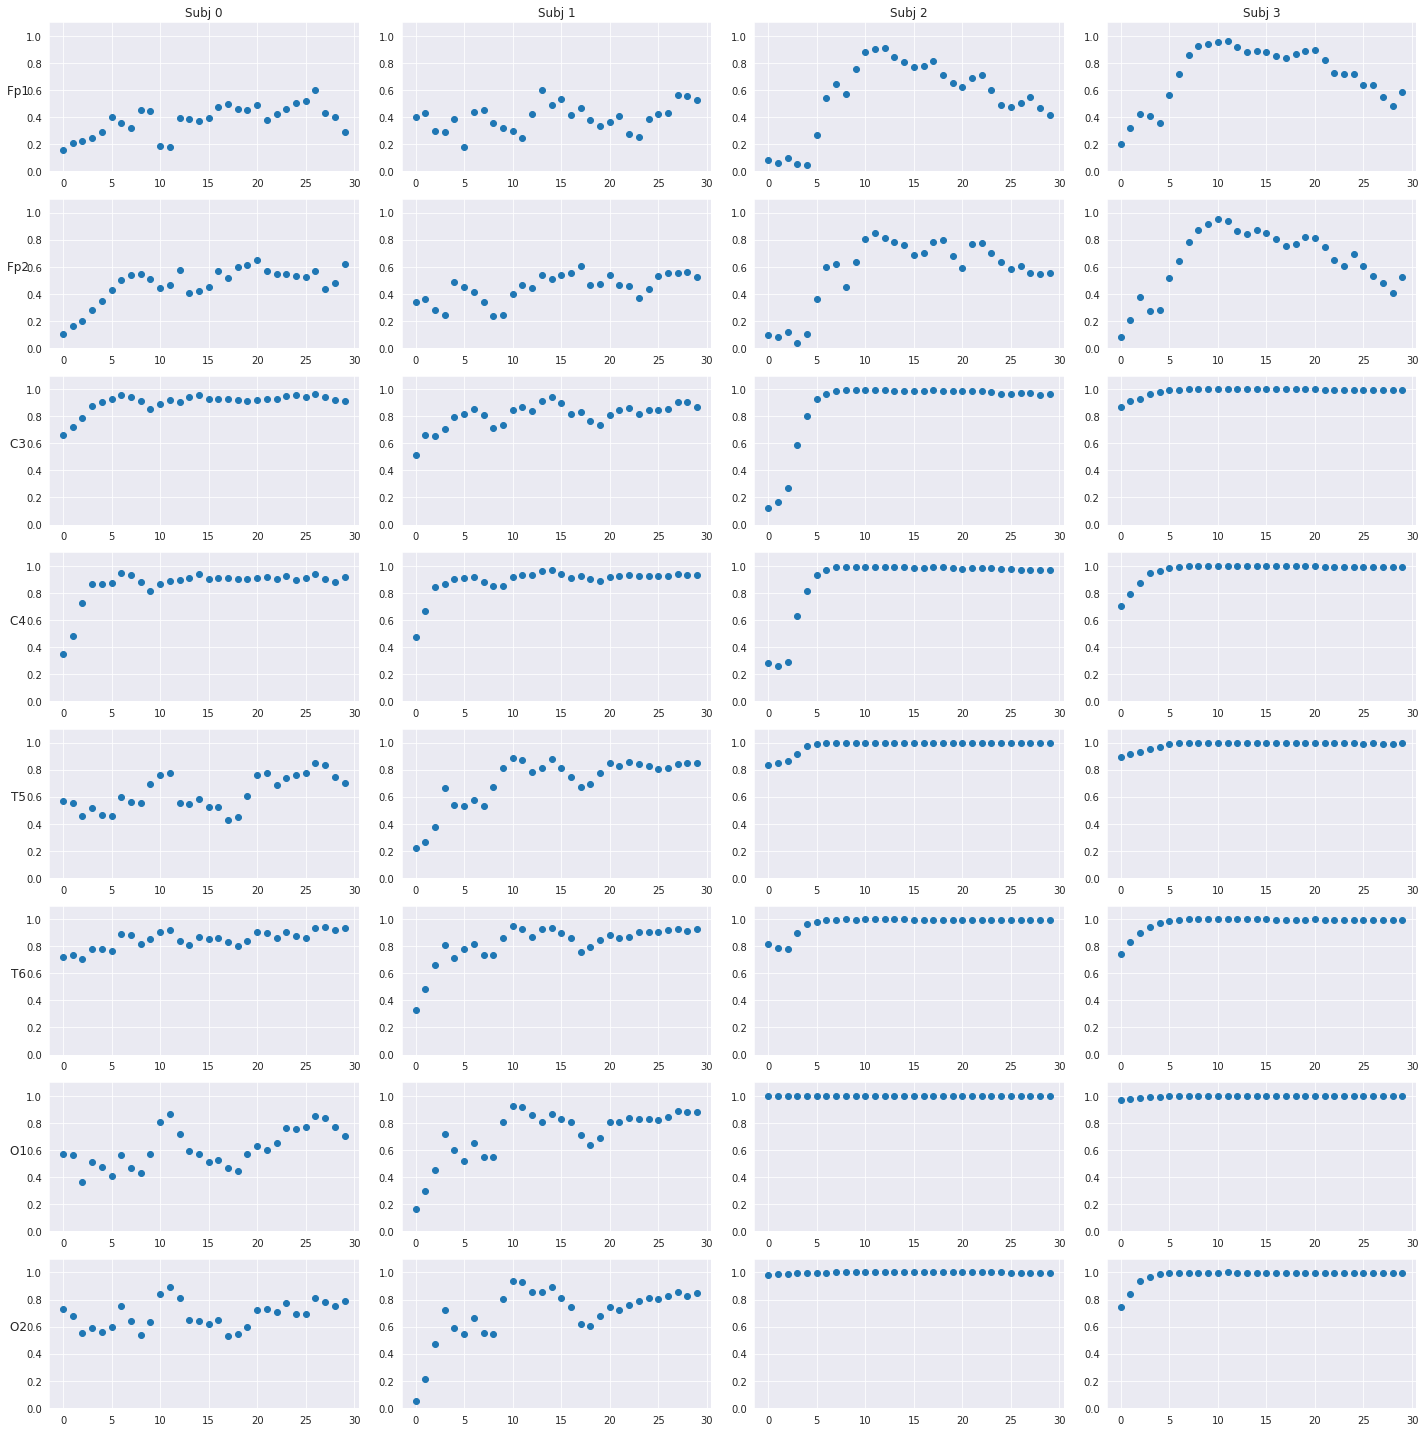

In [ ]:
cont_denoised_MSC_subjs = []

for idx_e_subject in range(number_subjects):
    manyCH_MSC = []
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_MSC = calculate_MSC(
            cont_EEG_e_CH=manyCH_contEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_MSC.append(oneCH_MSC)

    cont_denoised_MSC_subjs.append(manyCH_MSC)

cont_denoised_MSC_subjs = np.array(cont_denoised_MSC_subjs)
print(f'The shape of cont_denoised_MSC_subjs: {cont_denoised_MSC_subjs.shape}')

list_selected_electrodes_indices = [EEG_electrodes.index('Fp1'), EEG_electrodes.index('Fp2'),
                                    EEG_electrodes.index('C3'), EEG_electrodes.index('C4'),
                                    EEG_electrodes.index('T5'), EEG_electrodes.index('T6'),
                                    EEG_electrodes.index('O1'), EEG_electrodes.index('O2'),]
list_selected_electrodes = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1', 'O2']


# Plot MSC
fig, axs = plt.subplots(nrows=int(len(list_selected_electrodes_indices)),
                        ncols=4, figsize=(20,20))

cols = ['Subj {}'.format(col) for col in range(4)]
rows = ['{}  '.format(row) for row in list_selected_electrodes]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
    
for idx_e_ch, e_ch in enumerate(list_selected_electrodes_indices):
    l_freq = 0
    h_freq = 30

    axs[idx_e_ch,0].scatter(
        cont_denoised_MSC_subjs[0,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[0,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,0].set_ylim(0,1.1)

    axs[idx_e_ch,1].scatter(
        cont_denoised_MSC_subjs[1,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[1,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,1].set_ylim(0,1.1)

    axs[idx_e_ch,2].scatter(
        cont_denoised_MSC_subjs[2,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[2,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,2].set_ylim(0,1.1)

    axs[idx_e_ch,3].scatter(
        cont_denoised_MSC_subjs[3,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[3,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,3].set_ylim(0,1.1)

fig.tight_layout()
plt.show()

The shape of pure_PSD_subjs: (54, 19, 2, 101)
The shape of cont_PSD_subjs: (54, 19, 2, 101)
The shape of denoised_PSD_subjs: (54, 19, 2, 101)


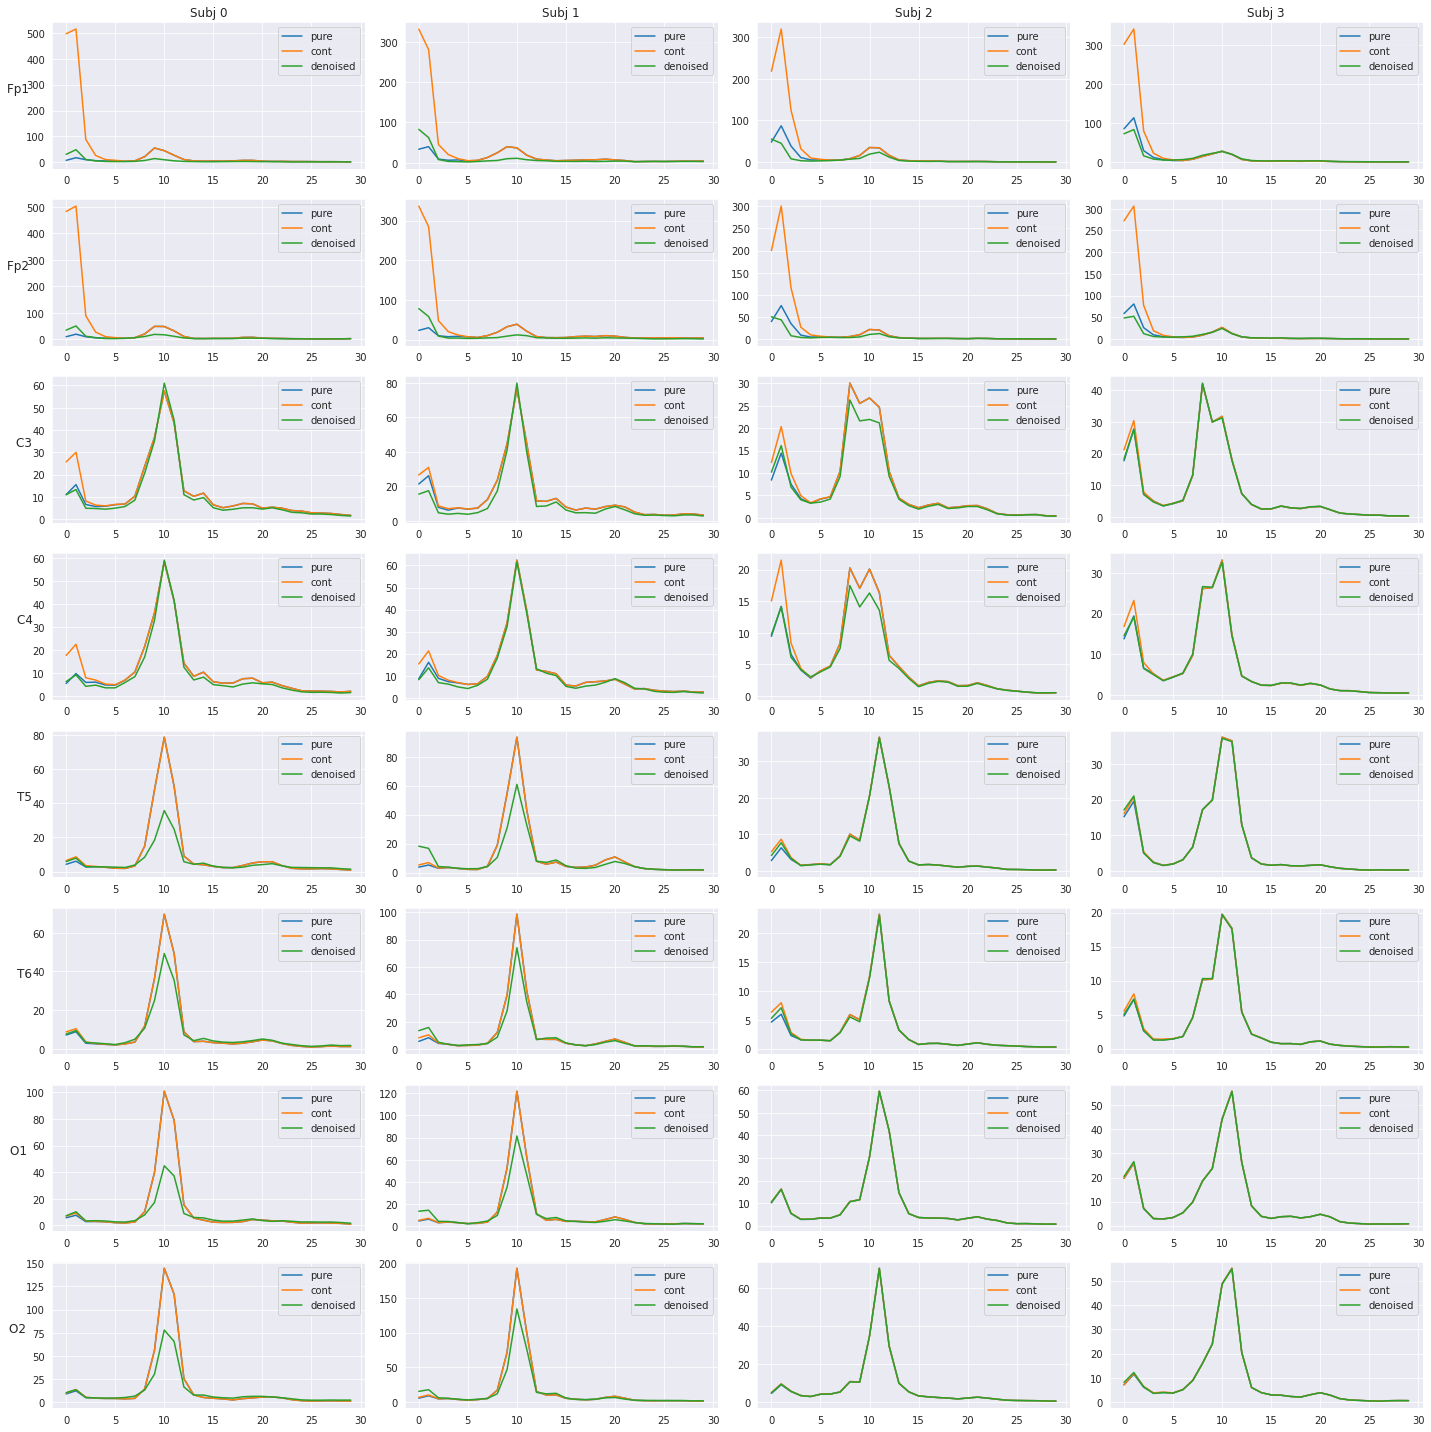

In [ ]:
pure_PSD_subjs = []
cont_PSD_subjs = []
denoised_PSD_subjs = []

for idx_e_subject in range(number_subjects):
    pure_PSD_CHs = []
    cont_PSD_CHs = []
    denoised_PSD_CHs = []

    manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_pure_PSD = calculate_PSD(manyCH_pureEEG[idx_channel])
        oneCH_cont_PSD = calculate_PSD(manyCH_contEEG[idx_channel])
        oneCH_denoised_PSD = calculate_PSD(manyCH_denoisedEEG[idx_channel])

        pure_PSD_CHs.append(oneCH_pure_PSD)
        cont_PSD_CHs.append(oneCH_cont_PSD)
        denoised_PSD_CHs.append(oneCH_denoised_PSD)

    pure_PSD_subjs.append(pure_PSD_CHs)
    cont_PSD_subjs.append(cont_PSD_CHs)
    denoised_PSD_subjs.append(denoised_PSD_CHs)

pure_PSD_subjs = np.array(pure_PSD_subjs)
cont_PSD_subjs = np.array(cont_PSD_subjs)
denoised_PSD_subjs = np.array(denoised_PSD_subjs)

print(f'The shape of pure_PSD_subjs: {pure_PSD_subjs.shape}')
print(f'The shape of cont_PSD_subjs: {cont_PSD_subjs.shape}')
print(f'The shape of denoised_PSD_subjs: {denoised_PSD_subjs.shape}')

list_selected_electrodes_indices = [EEG_electrodes.index('Fp1'), EEG_electrodes.index('Fp2'),
                                    EEG_electrodes.index('C3'), EEG_electrodes.index('C4'),
                                    EEG_electrodes.index('T5'), EEG_electrodes.index('T6'),
                                    EEG_electrodes.index('O1'), EEG_electrodes.index('O2'),]
list_selected_electrodes = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1', 'O2']

# Plot PSD
fig, axs = plt.subplots(nrows=int(len(list_selected_electrodes_indices)),
                        ncols=4, figsize=(20,20))

cols = ['Subj {}'.format(col) for col in range(4)]
rows = ['{}  '.format(row) for row in list_selected_electrodes]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
    
for idx_e_ch, e_ch in enumerate(list_selected_electrodes_indices):
    l_freq = 0
    h_freq = 30

    axs[idx_e_ch,0].plot(
        pure_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].plot(
        cont_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].plot(
        denoised_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,1].plot(
        pure_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[1,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,1].plot(
        cont_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[1,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,1].plot(
        denoised_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[1,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,1].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,2].plot(
        pure_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[2,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,2].plot(
        cont_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[2,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,2].plot(
        denoised_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[2,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,2].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,3].plot(
        pure_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[3,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,3].plot(
        cont_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[3,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,3].plot(
        denoised_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[3,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,3].legend(['pure', 'cont', 'denoised'])

fig.tight_layout()
plt.show()

# Save metrics

In [ ]:
!pwd
df_RMSE.to_csv(path_or_buf='save_results/02_ICA_RMSE.csv', 
               sep=',', float_format=None)
df_SAR.to_csv(path_or_buf='save_results/02_ICA_SAR.csv', 
               sep=',', float_format=None)


/content/drive/My Drive/Colab Notebooks/Thesis_st121166
